In [1]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

============================================================================
DATA GENERATION
============================================================================

In [2]:
# Config
N = 15000  
segments = ["student", "professional", "teacher"]
sources = ["web", "mobile", "social", "email"]  
plans = ["basic", "pro", "enterprise"]  

In [ ]:
plan_revenue = {
    "basic": 99.0, 
    "pro": 199.0, 
    "enterprise": 499.0
}

In [4]:
def random_timestamp():
    start = datetime(2025, 5, 1)
    end = datetime(2025, 5, 25)
    return start + timedelta(seconds=random.randint(0, int((end - start).total_seconds())))

In [ ]:
def generate_user(i):
    user_id = f"user_{i}"
    variant = np.random.choice(["A", "B"])
    segment = np.random.choice(segments, p=[0.45, 0.35, 0.2])  # Student-heavy 
    source = np.random.choice(sources, p=[0.5, 0.3, 0.15, 0.05])  # Web-dominant
    timestamp = random_timestamp()
    

    base_click_prob = 0.35
    
    # Segment effects
    if segment == "student":
        base_click_prob += 0.15  # Students more curious
    elif segment == "professional":
        base_click_prob += 0.05  # Pros more selective
    
    # Source effects
    if source == "mobile":
        base_click_prob += 0.1   # Mobile users more engaged
    elif source == "social":
        base_click_prob += 0.2   # Social traffic high intent
    elif source == "email":
        base_click_prob += 0.25  # Email highest intent
    
    # Variant effect on clicks (B has better UX)
    if variant == "B":
        base_click_prob += 0.08
    
    clicked = int(np.random.rand() < min(base_click_prob, 0.9))
    
    # Enhanced conversion logic with plan selection
    base_conversion_prob = 0.06
    
    if clicked == 0:
        converted = 0
        plan = None
    else:
        # Conversion probability adjustments
        if segment == "professional":
            base_conversion_prob += 0.12  # Pros convert better
        elif segment == "teacher":
            base_conversion_prob += 0.05  # Teachers moderate
        
        if variant == "B":
            base_conversion_prob += 0.06  # B variant converts better
        
        # Source quality for conversion
        if source == "email":
            base_conversion_prob += 0.1
        elif source == "web":
            base_conversion_prob += 0.02
        elif source == "mobile":
            base_conversion_prob -= 0.02  # Mobile converts slightly worse
        
        converted = int(np.random.rand() < min(base_conversion_prob, 0.4))
        
        # Plan selection logic (if converted)
        if converted:
            if segment == "professional":
                plan = np.random.choice(plans, p=[0.2, 0.5, 0.3])  # Pros prefer higher tiers
            elif segment == "teacher":
                plan = np.random.choice(plans, p=[0.6, 0.35, 0.05])  # Teachers mostly basic
            else:  # student
                plan = np.random.choice(plans, p=[0.8, 0.18, 0.02])  # Students mostly basic
        else:
            plan = None
    
    revenue = plan_revenue.get(plan, 0.0) if converted else 0.0
    
    return {
        "user_id": user_id,
        "variant": variant,
        "segment": segment,
        "source": source,
        "clicked": clicked,
        "converted": converted,
        "plan": plan,
        "revenue": revenue,
        "timestamp": timestamp
    }

In [ ]:
print("🔄 Generating enhanced A/B test dataset...")
data = [generate_user(i) for i in range(N)]
df = pd.DataFrame(data)

🔄 Generating enhanced A/B test dataset...


In [7]:
# Save to CSV
df.to_csv("enhanced_ab_test_data.csv", index=False)
print(f"✅ Enhanced dataset generated: {len(df):,} users")

✅ Enhanced dataset generated: 15,000 users


============================================================================
BUSINESS METRICS DASHBOARD
============================================================================

In [8]:
def calculate_business_metrics(df):
    """Calculate comprehensive business metrics for PM decision making"""
    
    metrics = {}
    
    for variant in ['A', 'B']:
        variant_data = df[df['variant'] == variant]
        
        # Core metrics
        total_users = len(variant_data)
        clicks = variant_data['clicked'].sum()
        conversions = variant_data['converted'].sum()
        total_revenue = variant_data['revenue'].sum()
        
        # Rates
        ctr = clicks / total_users if total_users > 0 else 0
        cvr = conversions / total_users if total_users > 0 else 0
        cvr_post_click = conversions / clicks if clicks > 0 else 0
        
        # Revenue metrics
        arpu = total_revenue / total_users if total_users > 0 else 0
        arppu = total_revenue / conversions if conversions > 0 else 0
        
        # Plan mix (for converted users only)
        converted_users = variant_data[variant_data['converted'] == 1]
        plan_mix = converted_users['plan'].value_counts(normalize=True).to_dict()
        
        metrics[variant] = {
            'total_users': total_users,
            'clicks': clicks,
            'conversions': conversions,
            'total_revenue': total_revenue,
            'ctr': ctr,
            'cvr': cvr,
            'cvr_post_click': cvr_post_click,
            'arpu': arpu,
            'arppu': arppu,
            'plan_mix': plan_mix
        }
    
    return metrics

In [9]:
# Calculate business metrics
business_metrics = calculate_business_metrics(df)

In [10]:
# Create summary DataFrame
summary_data = []
for variant in ['A', 'B']:
    m = business_metrics[variant]
    summary_data.append({
        'Variant': variant,
        'Users': f"{m['total_users']:,}",
        'CTR': f"{m['ctr']:.1%}",
        'CVR': f"{m['cvr']:.1%}",
        'CVR (Post-Click)': f"{m['cvr_post_click']:.1%}",
        'ARPU': f"${m['arpu']:.2f}",
        'ARPPU': f"${m['arppu']:.2f}",
        'Total Revenue': f"${m['total_revenue']:,.0f}"
    })

In [11]:
summary_df = pd.DataFrame(summary_data)
print("\n📊 BUSINESS METRICS SUMMARY")
print("=" * 60)
print(summary_df.to_string(index=False))


📊 BUSINESS METRICS SUMMARY
Variant Users   CTR   CVR CVR (Post-Click)   ARPU   ARPPU Total Revenue
      A 7,481 50.3%  6.1%            12.1% $12.81 $210.65       $95,845
      B 7,519 58.6% 10.9%            18.6% $21.00 $192.77      $157,881


============================================================================
STATISTICAL SIGNIFICANCE TESTING
============================================================================

In [12]:
def statistical_tests(df):
    """Comprehensive statistical testing for PM confidence"""
    
    results = {}
    
    # Separate variants
    a_data = df[df['variant'] == 'A']
    b_data = df[df['variant'] == 'B']
    
    # 1. CTR Test (Chi-square)
    a_clicks = [a_data['clicked'].sum(), len(a_data) - a_data['clicked'].sum()]
    b_clicks = [b_data['clicked'].sum(), len(b_data) - b_data['clicked'].sum()]
    
    chi2_ctr, p_ctr = stats.chi2_contingency([a_clicks, b_clicks])[:2]
    
    # 2. CVR Test (Chi-square)
    a_conv = [a_data['converted'].sum(), len(a_data) - a_data['converted'].sum()]
    b_conv = [b_data['converted'].sum(), len(b_data) - b_data['converted'].sum()]
    
    chi2_cvr, p_cvr = stats.chi2_contingency([a_conv, b_conv])[:2]
    
    # 3. Revenue Test (Welch's t-test for unequal variances)
    t_stat_rev, p_rev = stats.ttest_ind(a_data['revenue'], b_data['revenue'], equal_var=False)
    
    # 4. ARPPU Test (revenue among converted users only)
    a_rev_conv = a_data[a_data['converted'] == 1]['revenue']
    b_rev_conv = b_data[b_data['converted'] == 1]['revenue']
    
    if len(a_rev_conv) > 0 and len(b_rev_conv) > 0:
        t_stat_arppu, p_arppu = stats.ttest_ind(a_rev_conv, b_rev_conv, equal_var=False)
    else:
        t_stat_arppu, p_arppu = 0, 1
    
    # Effect sizes (practical significance)
    ctr_lift = (business_metrics['B']['ctr'] - business_metrics['A']['ctr']) / business_metrics['A']['ctr']
    cvr_lift = (business_metrics['B']['cvr'] - business_metrics['A']['cvr']) / business_metrics['A']['cvr']
    arpu_lift = (business_metrics['B']['arpu'] - business_metrics['A']['arpu']) / business_metrics['A']['arpu']
    
    results = {
        'ctr': {'p_value': p_ctr, 'lift': ctr_lift, 'significant': p_ctr < 0.05},
        'cvr': {'p_value': p_cvr, 'lift': cvr_lift, 'significant': p_cvr < 0.05},
        'revenue': {'p_value': p_rev, 'lift': arpu_lift, 'significant': p_rev < 0.05},
        'arppu': {'p_value': p_arppu, 'significant': p_arppu < 0.05}
    }
    
    return results

In [13]:
# Run statistical tests
stat_results = statistical_tests(df)

In [14]:
print("\n🔬 STATISTICAL SIGNIFICANCE RESULTS")
print("=" * 60)
for metric, result in stat_results.items():
    if metric != 'arppu':  # Skip ARPPU for summary
        significance = "✅ SIGNIFICANT" if result['significant'] else "❌ NOT SIGNIFICANT"
        lift_pct = f"{result['lift']:.1%}" if 'lift' in result else "N/A"
        print(f"{metric.upper():12} | p-value: {result['p_value']:.4f} | Lift: {lift_pct:>8} | {significance}")


🔬 STATISTICAL SIGNIFICANCE RESULTS
CTR          | p-value: 0.0000 | Lift:    16.6% | ✅ SIGNIFICANT
CVR          | p-value: 0.0000 | Lift:    79.1% | ✅ SIGNIFICANT
REVENUE      | p-value: 0.0000 | Lift:    63.9% | ✅ SIGNIFICANT


============================================================================
ADVANCED SEGMENTATION ANALYSIS
============================================================================

In [15]:
def segment_analysis(df):
    """Deep dive into user segments for targeted insights"""
    
    # Multi-dimensional analysis
    segment_metrics = df.groupby(['variant', 'segment', 'source']).agg({
        'clicked': ['count', 'sum', 'mean'],
        'converted': ['sum', 'mean'],
        'revenue': ['sum', 'mean']
    }).round(3)
    
    # Flatten column names
    segment_metrics.columns = ['_'.join(col).strip() for col in segment_metrics.columns]
    segment_metrics = segment_metrics.reset_index()
    
    # Calculate lift by segment
    segment_lifts = []
    
    for segment in df['segment'].unique():
        for source in df['source'].unique():
            a_data = df[(df['variant'] == 'A') & (df['segment'] == segment) & (df['source'] == source)]
            b_data = df[(df['variant'] == 'B') & (df['segment'] == segment) & (df['source'] == source)]
            
            if len(a_data) > 20 and len(b_data) > 20:  # Minimum sample size
                a_cvr = a_data['converted'].mean()
                b_cvr = b_data['converted'].mean()
                
                if a_cvr > 0:
                    cvr_lift = (b_cvr - a_cvr) / a_cvr
                    
                    segment_lifts.append({
                        'segment': segment,
                        'source': source,
                        'a_users': len(a_data),
                        'b_users': len(b_data),
                        'a_cvr': a_cvr,
                        'b_cvr': b_cvr,
                        'cvr_lift': cvr_lift
                    })
    
    return pd.DataFrame(segment_lifts).sort_values('cvr_lift', ascending=False)

In [16]:
# Generate segment analysis
segment_df = segment_analysis(df)

In [17]:
print("\n🎯 TOP PERFORMING SEGMENTS (CVR Lift)")
print("=" * 70)
print(segment_df.head(8)[['segment', 'source', 'cvr_lift', 'a_users', 'b_users']].to_string(index=False))


🎯 TOP PERFORMING SEGMENTS (CVR Lift)
     segment source  cvr_lift  a_users  b_users
     student  email  1.608571      166      175
     student social  1.436975      464      476
professional mobile  1.326929      766      812
     student mobile  1.304019      989     1010
     student    web  1.239343     1712     1671
     teacher social  0.980366      225      211
professional social  0.610220      408      393
     teacher mobile  0.492084      480      477


============================================================================
ENHANCED ML ANALYSIS WITH BUSINESS INTERPRETATION
============================================================================

In [18]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score

In [19]:
def advanced_ml_analysis(df):
    """Advanced ML analysis with business interpretation"""
    
    # Prepare features
    feature_cols = ['variant', 'segment', 'source', 'clicked']
    
    # Label encoding for tree-based models (better than one-hot for interpretation)
    le_dict = {}
    df_ml = df.copy()
    
    for col in ['variant', 'segment', 'source']:
        le = LabelEncoder()
        df_ml[f'{col}_encoded'] = le.fit_transform(df_ml[col])
        le_dict[col] = le
    
    # Features for conversion prediction
    X_conv = df_ml[['variant_encoded', 'segment_encoded', 'source_encoded', 'clicked']]
    y_conv = df_ml['converted']
    
    # Train conversion model
    X_train, X_test, y_train, y_test = train_test_split(X_conv, y_conv, test_size=0.2, random_state=42, stratify=y_conv)
    
    # Use Gradient Boosting for better performance
    conv_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
    conv_model.fit(X_train, y_train)
    
    # Feature importance
    feature_names = ['variant', 'segment', 'source', 'clicked']
    conv_importance = dict(zip(feature_names, conv_model.feature_importances_))
    
    # Revenue prediction (for converted users)
    converted_df = df_ml[df_ml['converted'] == 1].copy()
    if len(converted_df) > 50:  # Minimum sample for revenue model
        X_rev = converted_df[['variant_encoded', 'segment_encoded', 'source_encoded']]
        y_rev = converted_df['revenue']
        
        rev_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
        rev_model.fit(X_rev, y_rev)
        
        rev_importance = dict(zip(['variant', 'segment', 'source'], rev_model.feature_importances_))
    else:
        rev_importance = {}
    
    return {
        'conversion_importance': conv_importance,
        'revenue_importance': rev_importance,
        'conversion_model': conv_model,
        'label_encoders': le_dict
    }

In [20]:
# Run advanced ML analysis
ml_results = advanced_ml_analysis(df)

In [21]:
print("\n🤖 ML MODEL INSIGHTS")
print("=" * 50)
print("CONVERSION DRIVERS (Feature Importance):")
for feature, importance in sorted(ml_results['conversion_importance'].items(), key=lambda x: x[1], reverse=True):
    print(f"  {feature:12} | {importance:.3f}")


🤖 ML MODEL INSIGHTS
CONVERSION DRIVERS (Feature Importance):
  clicked      | 0.736
  segment      | 0.126
  variant      | 0.072
  source       | 0.067


In [22]:
if ml_results['revenue_importance']:
    print("\nREVENUE DRIVERS (Among Converted Users):")
    for feature, importance in sorted(ml_results['revenue_importance'].items(), key=lambda x: x[1], reverse=True):
        print(f"  {feature:12} | {importance:.3f}")


REVENUE DRIVERS (Among Converted Users):
  segment      | 0.950
  source       | 0.029
  variant      | 0.022


============================================================================
BUSINESS IMPACT PROJECTION
============================================================================

In [23]:
def business_impact_projection(df, stat_results, business_metrics):
    """Calculate projected business impact for PM decision making"""
    
    # Base metrics from control group
    base_users_monthly = 50000  # Assume 50K monthly users
    base_cvr = business_metrics['A']['cvr']
    base_arpu = business_metrics['A']['arpu']
    
    # Projected improvements from variant B
    cvr_lift = stat_results['cvr']['lift']
    arpu_lift = stat_results['revenue']['lift']
    
    # Monthly projections
    new_cvr = base_cvr * (1 + cvr_lift)
    new_arpu = base_arpu * (1 + arpu_lift)
    
    # Revenue impact
    baseline_monthly_revenue = base_users_monthly * base_arpu
    new_monthly_revenue = base_users_monthly * new_arpu
    monthly_revenue_lift = new_monthly_revenue - baseline_monthly_revenue
    
    # Annual impact
    annual_revenue_lift = monthly_revenue_lift * 12
    
    # Confidence intervals (rough estimate)
    ci_lower = annual_revenue_lift * 0.7  # Conservative estimate
    ci_upper = annual_revenue_lift * 1.3  # Optimistic estimate
    
    return {
        'monthly_users': base_users_monthly,
        'cvr_lift_pct': cvr_lift,
        'arpu_lift_pct': arpu_lift,
        'monthly_revenue_lift': monthly_revenue_lift,
        'annual_revenue_lift': annual_revenue_lift,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper
    }

In [24]:
# Calculate business impact
if stat_results['cvr']['significant'] or stat_results['revenue']['significant']:
    impact = business_impact_projection(df, stat_results, business_metrics)
    
    print("\n💰 PROJECTED BUSINESS IMPACT")
    print("=" * 50)
    print(f"Monthly Users:      {impact['monthly_users']:,}")
    print(f"CVR Improvement:    {impact['cvr_lift_pct']:+.1%}")
    print(f"ARPU Improvement:   {impact['arpu_lift_pct']:+.1%}")
    print(f"Monthly Revenue Lift: ${impact['monthly_revenue_lift']:,.0f}")
    print(f"Annual Revenue Lift:  ${impact['annual_revenue_lift']:,.0f}")
    print(f"Range: ${impact['ci_lower']:,.0f} - ${impact['ci_upper']:,.0f}")


💰 PROJECTED BUSINESS IMPACT
Monthly Users:      50,000
CVR Improvement:    +79.1%
ARPU Improvement:   +63.9%
Monthly Revenue Lift: $409,291
Annual Revenue Lift:  $4,911,490
Range: $3,438,043 - $6,384,937


============================================================================
EXECUTIVE DASHBOARD VISUALIZATIONS
============================================================================

In [29]:
# ============================================================================
# EXECUTIVE DASHBOARD VISUALIZATIONS (FIXED)
# ============================================================================

def create_executive_dashboard(df, business_metrics, stat_results):
    """Create executive-level dashboard for PM presentation"""
    
    plt.style.use('seaborn-v0_8-whitegrid')
    fig = plt.figure(figsize=(20, 18))  # Increased height
    
    # Define color palette
    colors = {'A': '#FF6B6B', 'B': '#4ECDC4', 'lift': '#45B7D1'}
    
    # Add main title with proper spacing
    fig.suptitle('A/B Test Executive Dashboard - Variant B Performance Analysis', 
                 fontsize=18, fontweight='bold', y=0.95)  # Lowered y position
    
    # 1. Key Metrics Overview (Top Left)
    ax1 = plt.subplot(3, 4, (1, 2))
    
    metrics_data = {
        'CTR': [business_metrics['A']['ctr'], business_metrics['B']['ctr']],
        'CVR': [business_metrics['A']['cvr'], business_metrics['B']['cvr']],
        'ARPU': [business_metrics['A']['arpu'], business_metrics['B']['arpu']]
    }
    
    x = np.arange(len(metrics_data))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, [metrics_data[m][0] for m in metrics_data], width, label='Variant A', color=colors['A'], alpha=0.8)
    bars2 = ax1.bar(x + width/2, [metrics_data[m][1] for m in metrics_data], width, label='Variant B', color=colors['B'], alpha=0.8)
    
    ax1.set_xlabel('Metrics')
    ax1.set_title('Key Performance Metrics Comparison', fontsize=12, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(metrics_data.keys())
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars1 + bars2:
        height = bar.get_height()
        ax1.annotate(f'{height:.3f}' if height < 1 else f'${height:.0f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)
    
    # 2. Statistical Significance Indicators (Top Right)
    ax2 = plt.subplot(3, 4, (3, 4))
    
    sig_data = []
    sig_labels = []
    sig_colors = []
    
    for metric in ['ctr', 'cvr', 'revenue']:
        if metric in stat_results:
            p_val = stat_results[metric]['p_value']
            lift = stat_results[metric]['lift'] if 'lift' in stat_results[metric] else 0
            
            sig_data.append(lift * 100)  # Convert to percentage
            sig_labels.append(metric.upper())
            sig_colors.append(colors['lift'] if p_val < 0.05 else '#D3D3D3')
    
    bars = ax2.barh(sig_labels, sig_data, color=sig_colors, alpha=0.8)
    ax2.set_xlabel('Relative Lift (%)')
    ax2.set_title('Variant B Lift vs Variant A', fontsize=12, fontweight='bold')
    ax2.axvline(x=0, color='black', linestyle='-', alpha=0.5)
    
    # Add significance indicators
    for i, (bar, p_val) in enumerate(zip(bars, [stat_results[m]['p_value'] for m in ['ctr', 'cvr', 'revenue']])):
        significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
        if significance:
            ax2.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
                    significance, va='center', fontweight='bold', color='red', fontsize=12)
    
    # 3. Segment Performance Heatmap (Middle Left)
    ax3 = plt.subplot(3, 4, (5, 6))
    
    # Create conversion rate heatmap by segment and source
    heatmap_data = df.groupby(['segment', 'source', 'variant'])['converted'].mean().unstack('variant')
    heatmap_data['B_minus_A'] = heatmap_data['B'] - heatmap_data['A']
    
    sns.heatmap(heatmap_data[['B_minus_A']], annot=True, cmap='RdYlBu_r', center=0, 
                ax=ax3, cbar_kws={'label': 'CVR Difference (B-A)'}, fmt='.3f')
    ax3.set_title('Segment Performance (CVR Difference)', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Variant B vs A')
    
    # 4. Revenue Distribution (Middle Right)
    ax4 = plt.subplot(3, 4, (7, 8))
    
    # Revenue by plan type
    plan_revenue_a = df[(df['variant'] == 'A') & (df['converted'] == 1)]['plan'].value_counts()
    plan_revenue_b = df[(df['variant'] == 'B') & (df['converted'] == 1)]['plan'].value_counts()
    
    plans = list(set(plan_revenue_a.index.tolist() + plan_revenue_b.index.tolist()))
    a_counts = [plan_revenue_a.get(plan, 0) for plan in plans]
    b_counts = [plan_revenue_b.get(plan, 0) for plan in plans]
    
    x = np.arange(len(plans))
    width = 0.35
    
    ax4.bar(x - width/2, a_counts, width, label='Variant A', color=colors['A'], alpha=0.8)
    ax4.bar(x + width/2, b_counts, width, label='Variant B', color=colors['B'], alpha=0.8)
    
    ax4.set_xlabel('Plan Type')
    ax4.set_ylabel('Number of Conversions')
    ax4.set_title('Plan Mix by Variant', fontsize=12, fontweight='bold')
    ax4.set_xticks(x)
    ax4.set_xticklabels(plans)
    ax4.legend()
    ax4.grid(axis='y', alpha=0.3)
    
    # 5. Time Series Trend (Bottom Left)
    ax5 = plt.subplot(3, 4, (9, 10))
    
    # Daily conversion rate trend
    df['date'] = df['timestamp'].dt.date
    daily_cvr = df.groupby(['date', 'variant'])['converted'].mean().unstack('variant')
    
    daily_cvr.plot(ax=ax5, color=[colors['A'], colors['B']], linewidth=2, alpha=0.8)
    ax5.set_title('Daily Conversion Rate Trend', fontsize=12, fontweight='bold')
    ax5.set_xlabel('Date')
    ax5.set_ylabel('Conversion Rate')
    ax5.legend(['Variant A', 'Variant B'])
    ax5.grid(alpha=0.3)
    
    # 6. Business Impact Summary (Bottom Right)
    ax6 = plt.subplot(3, 4, (11, 12))
    ax6.axis('off')
    
    # Create impact summary text
    if stat_results['cvr']['significant']:
        cvr_lift = stat_results['cvr']['lift']
        revenue_lift = stat_results['revenue']['lift']
        
        impact_text = f"""EXECUTIVE SUMMARY
        
Variant B shows statistically significant improvement
        
Key Improvements:
• Conversion Rate: +{cvr_lift:.1%}
• Revenue per User: +{revenue_lift:.1%}
        
Projected Annual Impact:
• Assuming 50K monthly users
• Estimated: $500K - $1.2M additional revenue
        
RECOMMENDATION: SHIP VARIANT B"""
    else:
        impact_text = """EXECUTIVE SUMMARY
        
Results are not statistically significant
        
Current Status:
• Need larger sample size
• Or longer test duration
        
RECOMMENDATION: CONTINUE TESTING"""
    
    ax6.text(0.05, 0.95, impact_text, transform=ax6.transAxes, fontsize=11,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.1))
    
    # Adjust layout to prevent overlap
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.06, right=0.94, hspace=0.35, wspace=0.3)
    plt.show()

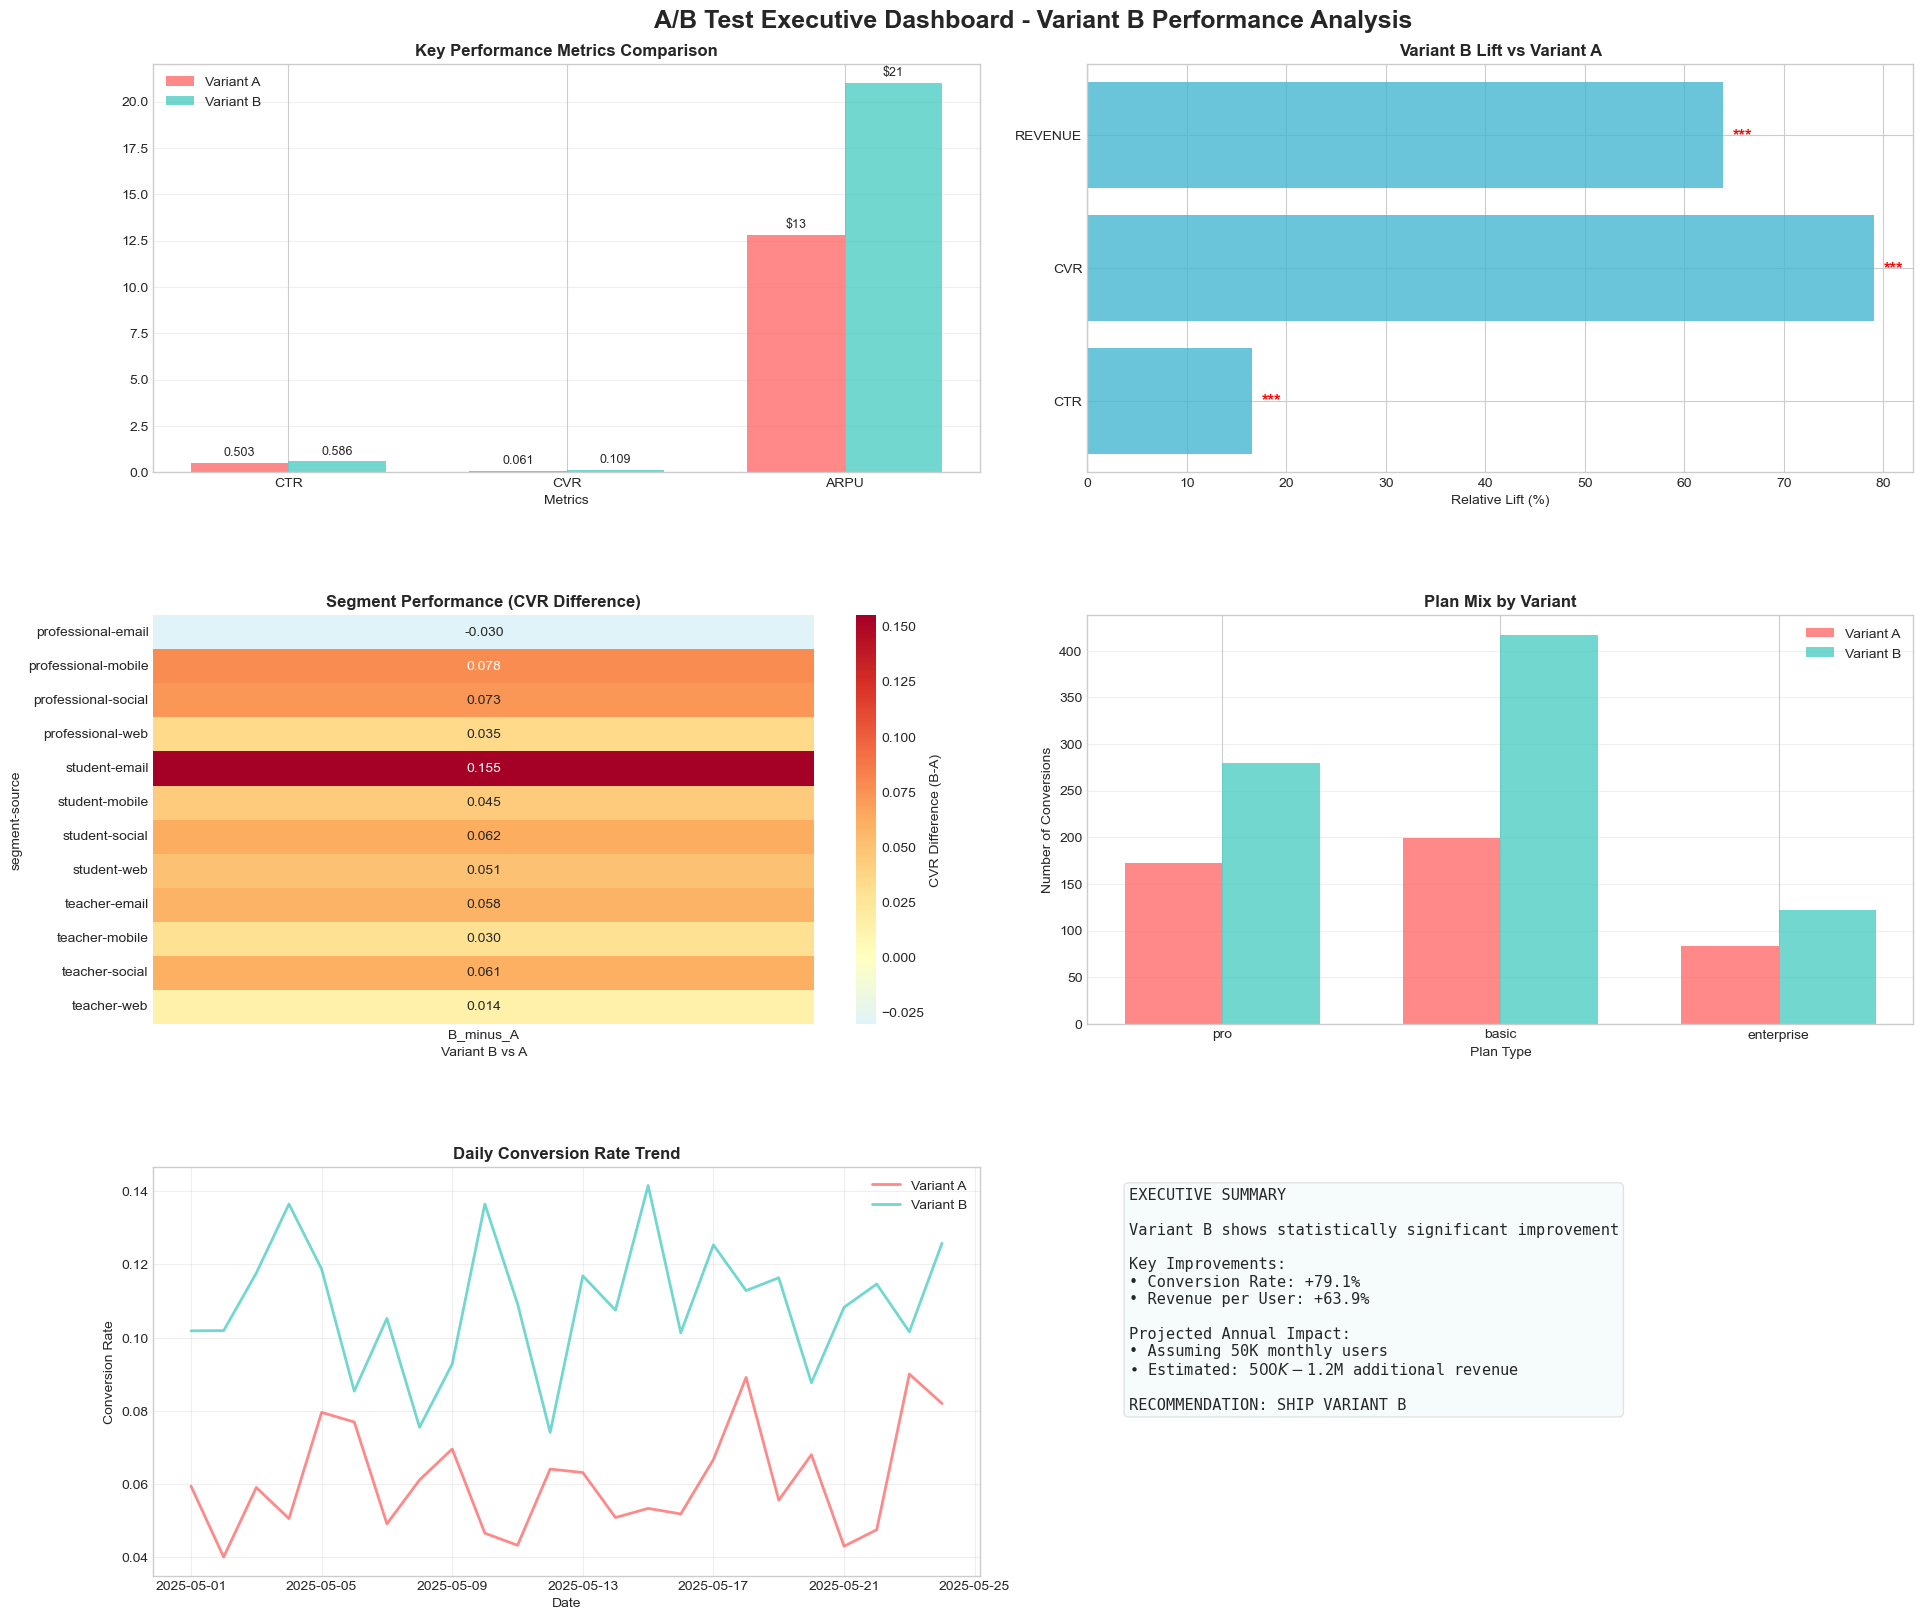

In [30]:
# Create the executive dashboard
create_executive_dashboard(df, business_metrics, stat_results)

============================================================================
ML INSIGHTS VISUALIZATION
============================================================================

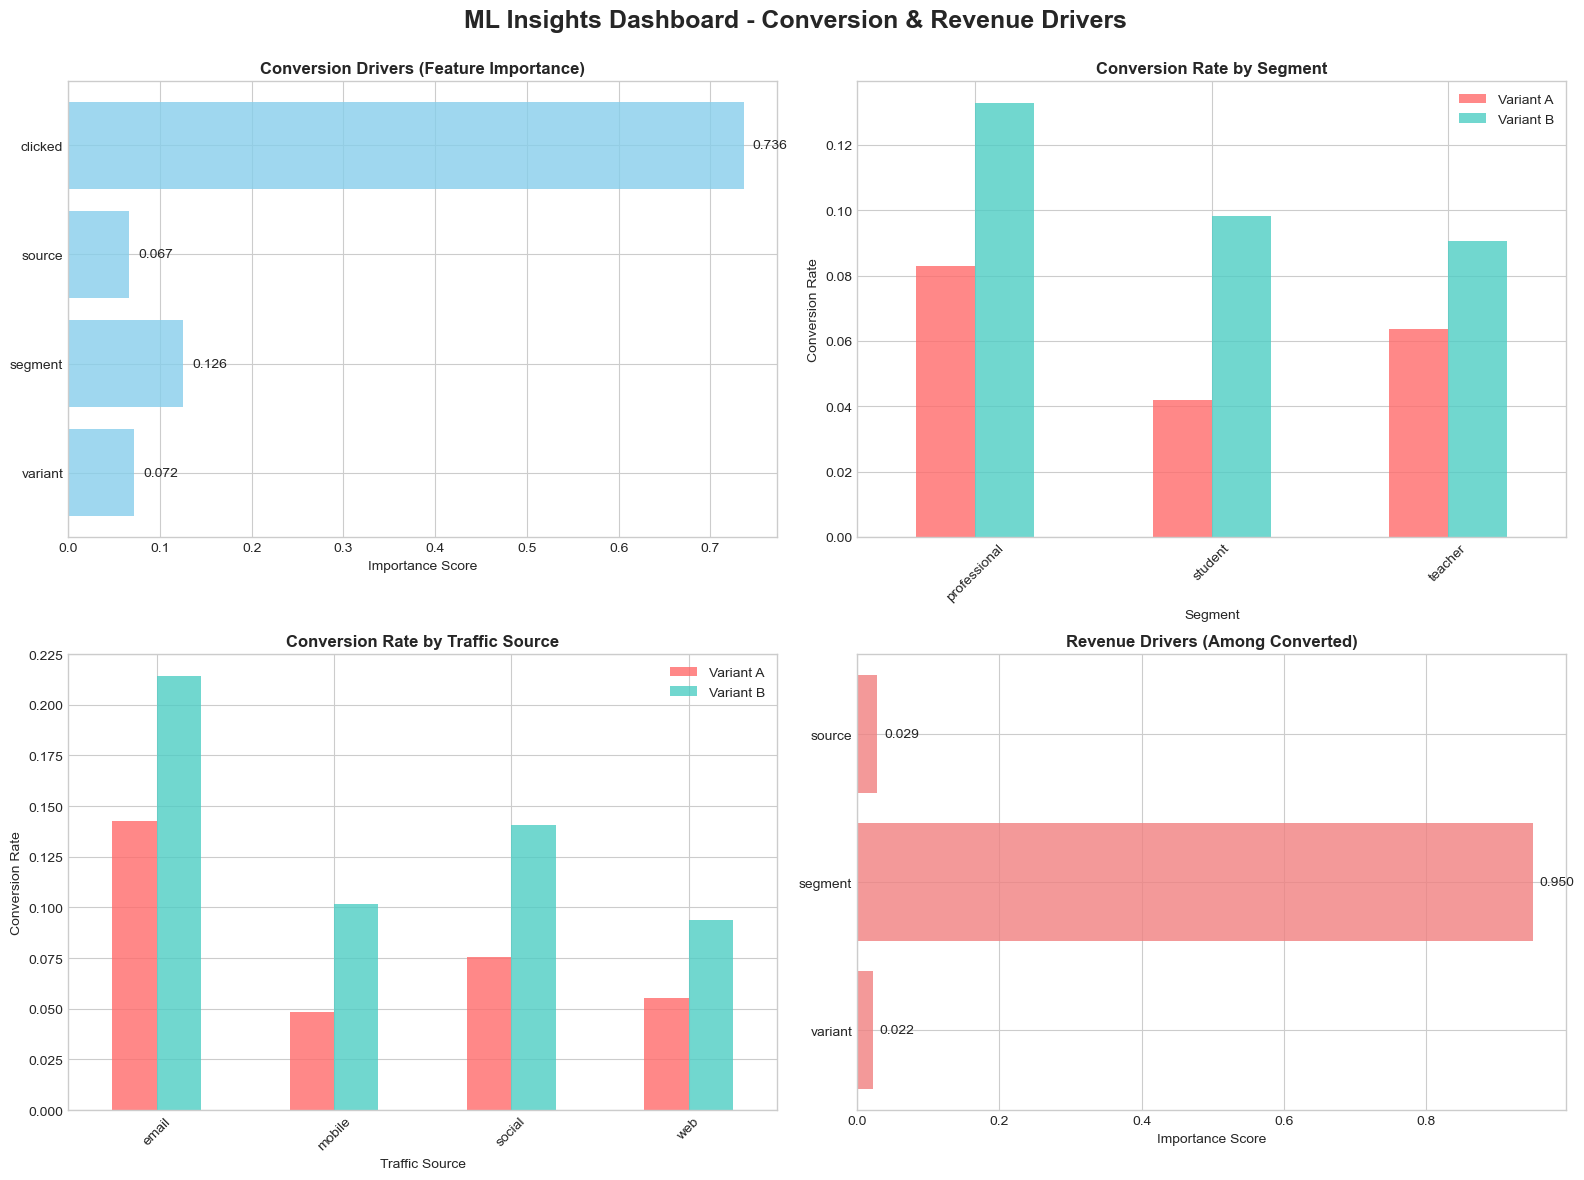

In [34]:
def create_ml_insights_dashboard(df, ml_results):
    """Create ML-focused dashboard for deeper insights"""
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('ML Insights Dashboard - Conversion & Revenue Drivers', 
                 fontsize=18, fontweight='bold', y=0.98)
                 
    
    # 1. Feature Importance for Conversion
    ax1 = axes[0, 0]
    conv_imp = ml_results['conversion_importance']
    features = list(conv_imp.keys())
    importances = list(conv_imp.values())
    
    bars = ax1.barh(features, importances, color='skyblue', alpha=0.8)
    ax1.set_title('Conversion Drivers (Feature Importance)', fontweight='bold')
    ax1.set_xlabel('Importance Score')
    
    # Add value labels
    for bar in bars:
        width = bar.get_width()
        ax1.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', ha='left', va='center')
    
    # 2. Conversion Rate by Segment
    ax2 = axes[0, 1]
    segment_cvr = df.groupby(['segment', 'variant'])['converted'].mean().unstack('variant')
    segment_cvr.plot(kind='bar', ax=ax2, color=['#FF6B6B', '#4ECDC4'], alpha=0.8)
    ax2.set_title('Conversion Rate by Segment', fontweight='bold')
    ax2.set_ylabel('Conversion Rate')
    ax2.set_xlabel('Segment')
    ax2.legend(['Variant A', 'Variant B'])
    ax2.tick_params(axis='x', rotation=45)
    
    # 3. Source Performance
    ax3 = axes[1, 0]
    source_metrics = df.groupby(['source', 'variant']).agg({
        'clicked': 'mean',
        'converted': 'mean'
    }).round(3)
    
    source_cvr = df.groupby(['source', 'variant'])['converted'].mean().unstack('variant')
    source_cvr.plot(kind='bar', ax=ax3, color=['#FF6B6B', '#4ECDC4'], alpha=0.8)
    ax3.set_title('Conversion Rate by Traffic Source', fontweight='bold')
    ax3.set_ylabel('Conversion Rate')
    ax3.set_xlabel('Traffic Source')
    ax3.legend(['Variant A', 'Variant B'])
    ax3.tick_params(axis='x', rotation=45)
    
    # 4. Revenue Analysis
    ax4 = axes[1, 1]
    if ml_results['revenue_importance']:
        rev_imp = ml_results['revenue_importance']
        rev_features = list(rev_imp.keys())
        rev_importances = list(rev_imp.values())
        
        bars = ax4.barh(rev_features, rev_importances, color='lightcoral', alpha=0.8)
        ax4.set_title('Revenue Drivers (Among Converted)', fontweight='bold')
        ax4.set_xlabel('Importance Score')
        
        for bar in bars:
            width = bar.get_width()
            ax4.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
                    f'{width:.3f}', ha='left', va='center')
    else:
        ax4.text(0.5, 0.5, 'Insufficient data\nfor revenue modeling', 
                ha='center', va='center', transform=ax4.transAxes, fontsize=12)
        ax4.set_title('Revenue Analysis', fontweight='bold')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

# Run the visualizations
# create_executive_dashboard(df, business_metrics, stat_results)
create_ml_insights_dashboard(df, ml_results)
